# Identifying CpGs behind PaCMAP

```{contents}
```

## Load data

In [1]:
import pandas as pd
from source.pacmap_functions import *

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'df_discovery.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'df_validation.pkl').sort_index()

# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

# Load clinical data
validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

# Adjust clinical data
discovery_clinical_data['Train Test'] = 'Discovery (train) Samples'
validation_clinical_data['Train Test'] = 'Validation (test) Samples'

discovery_clinical_data['PaCMAP Output'] = 'Patient Samples'
validation_clinical_data['PaCMAP Output'] = 'Patient Samples'

discovery_clinical_data['Batch'] = df_discovery['Batch']
validation_clinical_data['Batch'] = 'St Jude Children\'s'

# use overlapping features between df_discovery and df_validation
common_features = [x for x in df_discovery.columns if x in df_validation.columns]

# apply `common_features` to both df_discovery and df_validation
df_discovery = df_discovery[common_features]
df_validation = df_validation[common_features]

print(
f' Discovery dataset (df_discovery) contains {df_discovery.shape[1]} \
columns (5mC nucleotides/probes) and {df_discovery.shape[0]} rows (samples).')

print(
f' Validation dataset (df_validation) contains {df_validation.shape[1]} \
columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

 Discovery dataset (df_discovery) contains 319738 columns (5mC nucleotides/probes) and 3330 rows (samples).
 Validation dataset (df_validation) contains 319738 columns (5mC nucleotides/probes) and 201 rows (samples).


In [ ]:
# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=1)

pacmap_components = df[df['Train Test'] == 'Discovery (train) Samples'][['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']]

df_discovery = df_discovery[df_discovery.index.isin(pacmap_components.index)]

df_discovery.shape, pacmap_components.shape # ((3059, 319738), (3059, 5))

df_discovery2 = df_discovery.iloc[:, :50]

df_discovery2.shape # (3059, 50)

## Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Let's say you want to find feature importance for 'PaCMAP 1'
target = pacmap_components['PaCMAP 1']
features = df_discovery2

# Train a RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(features, target)

# Get feature importances
importances = model.feature_importances_

# Sort features by importance
feature_importances = pd.DataFrame({"Feature": features.columns, "Importance": importances})
feature_importances = feature_importances.sort_values("Importance", ascending=False)


In [62]:
feature_importances.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
20,cg00001583,0.207166
15,cg00001269,0.103107
1,cg00000363,0.079353
23,cg00001747,0.078024
45,cg00002646,0.059371
30,cg00002033,0.046577
4,cg00000714,0.043796
0,cg00000292,0.038904
31,cg00002080,0.027334
47,cg00002719,0.022383


In [63]:
from sklearn.inspection import plot_partial_dependence

# We'll just take the top 5 important features for the sake of the example
important_features = feature_importances['Feature'][:5]

# Plot the partial dependence of the model's prediction on each of the important features
fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(model, features, important_features, ax=ax)
plt.show()


ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/inspection/__init__.py)

## Canonical Correlation Analysis (CCA)

- __CCA__: Canonical Correlation Analysis

- __Scikit-Learn API__: [Code Reference](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html), [User Guide](https://scikit-learn.org/stable/modules/cross_decomposition.html#id5)

- __Reference__: [A survey of Partial Least Squares (PLS) methods, with emphasis on the two-block case](https://stat.uw.edu/sites/default/files/files/reports/2000/tr371.pdf)

CCA is a multivariate statistical method that is used to understand the relationships between two sets of variables or multi-dimensional data. The method investigates the possible correlations between linear combinations of variables in two data sets.

**How does it work?**

CCA constructs a pair of linear combinations, one for each data set, such that the correlation between these two linear combinations (canonical variables or canonical scores) is maximized. 

In mathematical terms, suppose we have two data sets X and Y, where X is an n x p matrix and Y is an n x q matrix. CCA seeks to find vectors a and b such that the correlation between Xa and Yb is maximized. The vectors a and b are known as canonical weights, and the correlation between Xa and Yb is called the canonical correlation. 

The procedure is repeated to find additional pairs of canonical variables that are uncorrelated with the previously obtained pairs, up to min(p, q) pairs can be found. The analysis provides canonical correlation coefficients, canonical weights, and loadings (the correlation between the variables and their respective canonical variables) for each pair.

**Interpreting the results of CCA:**

The results of CCA can provide insights about the relationships between the two sets of variables. Here's how you can interpret these results:

1. **Canonical Correlations**: These are the correlations between the pairs of canonical variables. These correlations can be used to determine the strength and significance of the relationship between the two sets of variables. The larger the canonical correlation, the stronger the relationship between the linear combinations of variables.

2. **Canonical Weights**: These weights show the contribution of each variable to the canonical variable. They can help to identify the variables that contribute the most to the relationship between the two sets of variables.

3. **Canonical Loadings**: These are the correlations between the original variables and the canonical variables. The loadings can give additional insights about the relationships between the variables.

4. **Canonical Cross-loadings**: These are the correlations between the variables from one set and the canonical variable from the other set. They can provide insights about the relationships between the variables across the two sets.

5. **Redundancy Analysis**: It measures the amount of variance shared between the data sets. It is used to assess how much information from one set can be inferred from the other set.

The number of significant canonical correlations (often determined using a statistical test like Wilks' Lambda) indicates the number of meaningful dimensions that connect the two data sets.

In [2]:
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=1)

pacmap_components = df[df['Train Test'] == 'Discovery (train) Samples'][['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']]

df_discovery = df_discovery[df_discovery.index.isin(pacmap_components.index)]

df_discovery.shape, pacmap_components.shape # ((3059, 319738), (3059, 5))

df_discovery2 = df_discovery.iloc[:, :50]

df_discovery2.shape # (3059, 50)

# Let's perform CCA between the scaled high-dimensional data and the PaCMAP components
X = df_discovery2
Y = pacmap_components.values  # convert dataframe to numpy array

# Create a CCA object
cca = CCA(n_components=5)  # we are considering all 5 PaCMAP components

# Fit the CCA model
cca.fit(X, Y)

# Apply the dimensionality reduction on X and Y
X_c, Y_c = cca.transform(X, Y)

In [3]:
import numpy as np
import pandas as pd

# Compute the correlation between the original variables and the canonical variables

# Canonical loadings for X
loadings_X = pd.DataFrame(np.corrcoef(X.values.T, X_c.T)[:-5, -5:],
                          index=X.columns,
                          columns=[f'CV_{i+1}' for i in range(X_c.shape[1])])

# Canonical loadings for Y
loadings_Y = pd.DataFrame(np.corrcoef(Y.T, Y_c.T)[:-5, -5:],
                          index=pacmap_components.columns,
                          columns=[f'CV_{i+1}' for i in range(Y_c.shape[1])])


In [6]:
loadings_X

,CV_1,CV_2,CV_3,CV_4,CV_5
IlmnID,,,,,
cg00000292,0.569845,0.540227,-0.221803,-0.092604,-0.061662
cg00000363,0.511640,-0.098322,-0.269679,0.179906,0.194431
cg00000622,0.022052,-0.008374,0.008219,-0.007270,0.007513
cg00000658,-0.012525,-0.016368,0.030923,-0.040388,0.038702
cg00000714,0.524283,-0.057606,-0.050835,-0.237961,0.066208
cg00000721,0.069605,0.007658,0.010546,-0.026595,-0.042978
cg00000734,-0.224310,0.018410,0.089375,0.032044,-0.081114
cg00000769,-0.052612,0.099970,0.121503,0.055431,-0.195943
cg00000884,-0.045733,0.042012,-0.032079,-0.034418,-0.026150


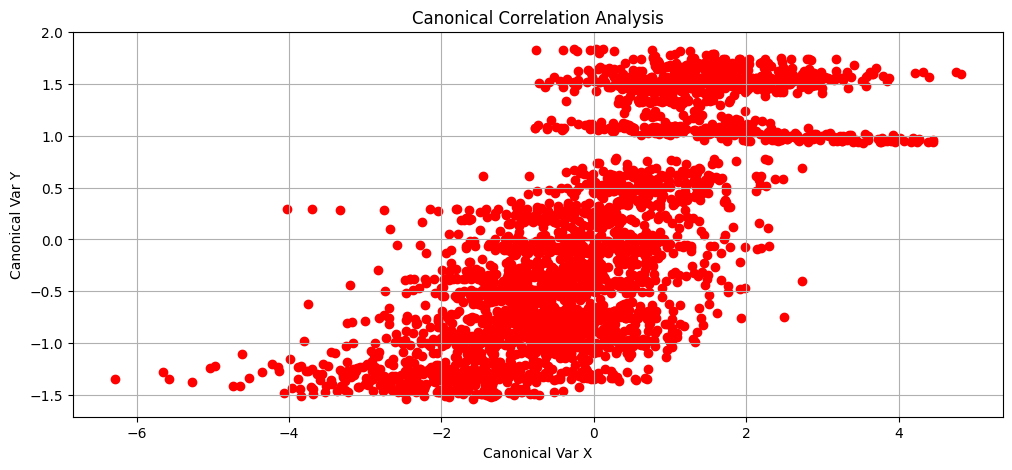

In [53]:
# Visualization of the first canonical variable (since it's 5D, we can't plot all dimensions together)
plt.figure(figsize=(12,5))
plt.scatter(X_c[:,0], Y_c[:,0], color='red')  # adjust indices to view other pairs
plt.title('Canonical Correlation Analysis')
plt.xlabel('Canonical Var X')
plt.ylabel('Canonical Var Y')
plt.grid()
plt.show()

In [54]:
# Convert X_c and Y_c to pandas DataFrame
X_c_df = pd.DataFrame(X_c, index=df_discovery.index)
Y_c_df = pd.DataFrame(Y_c, index=pacmap_components.index)

# Naming the columns appropriately
X_c_df.columns = ['X_CanVar_' + str(i+1) for i in range(X_c_df.shape[1])]
Y_c_df.columns = ['Y_CanVar_' + str(i+1) for i in range(Y_c_df.shape[1])]

In [56]:
Y_c_df

,Y_CanVar_1,Y_CanVar_2,Y_CanVar_3,Y_CanVar_4,Y_CanVar_5
index,,,,,
0003fe29-7b8f-4ef1-b9bc-40306205f1fd_noid,1.592853,0.673277,0.946674,0.907160,1.655053
0031efba-f564-4fff-bd7b-2b97f37218c1_noid,-0.098199,1.302559,0.146538,0.182434,-0.415301
0037ec75-bb9e-4dbb-a2d9-de1f9bfd2362_noid,1.546186,-0.277852,1.000163,-0.889728,0.035595
003d9efe-90a1-42cf-84c4-03fbabefe60b_noid,-0.417293,1.055394,0.522398,-1.648367,1.170960
004c953f-d999-4d82-898d-c091e692df3c_noid,-0.737794,1.870255,0.695930,0.233077,1.365336
...,...,...,...,...,...
fd4e4be4-3306-4037-b4e9-7886283243ed_noid,1.017511,-0.397367,-0.363905,1.521424,-0.901795
fe185655-3aa5-4c5c-9dfd-630e0ee71710_noid,-1.359375,-1.319577,1.151866,0.820086,-0.078192
ff7f7d14-5fb7-44bc-b67a-d07610873330_noid,-0.128957,1.302219,0.111696,0.402092,-0.404264
